In [121]:
# Importing necessary libraries for data manipulation
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
from scipy import stats
from tqdm import tqdm

# Importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Setting Up the Environment for Data Analysis, Visualization, and Machine Learning

#### Libraries and Modules Used:

- **Data Analysis and Wrangling**:
  - **`numpy`**: Provides support for efficient numerical computation, essential for handling large data arrays and matrices.
  - **`pandas`**: Offers data structures and operations for manipulating numerical tables and time series. It is fundamental for data cleaning, preparation, and analysis tasks.
  - **`math`**: Mathematical functions defined by the C standard.
  - **`tqdm`**: Fast, extensible progress bar library for Python.
  - **`scipy`**: Open-source Python library used for scientific and technical computing.
&nbsp;
- **Visualization Tools**:
  - **`seaborn`**: A Python data visualization library based on matplotlib that provides a high-level interface for drawing attractive statistical graphics.
  - **`matplotlib.pyplot`**: A collection of functions that make matplotlib work like MATLAB. It is used to create figures and plots for data visualization.

### Project Continuation with Data Mining Models and Techniques

Using the datasets created in the prior **Milestone** notebook, "IE7275_Project_TAT", this section performs data mining tasks on the curated datesets.
- **primary_stations_df**: Curated NOAA stations for the contiguous 48 states for the US.
- **temp_2024_df**: Processed 2024 temperature data from stations in the contiguoug 48 states for the US.

### Data Acquisition

In [27]:
# Read CSV files from previous processing
primary_stations_df = pd.read_csv('primary_stations_df.csv')
temp_2024_df = pd.read_csv('2024_df.csv')

In [29]:
primary_stations_df.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE
0,US009052008,43.7333,-96.6333,482.0,SD
1,USC00010063,34.2108,-87.1783,239.6,AL
2,USC00010148,34.2333,-86.1667,348.1,AL
3,USC00010160,32.9350,-85.9556,201.2,AL
4,USC00010163,32.9833,-85.8667,200.9,AL


In [31]:
temp_2024_df.head()

,ID,DATE,TAVG,WEEK
0,USC00010063,2024-01-01,55.5,1
1,USC00010063,2024-01-02,11.5,1
2,USC00010063,2024-01-03,22.0,1
3,USC00010063,2024-01-04,-3.0,1
4,USC00010063,2024-01-05,-8.5,1


### Spatial Interpolation

As part of our strategy for addressing missing data in the **temp_2024_df** in which the number of potential observations is 94.39%, we will perform data interpolation by using temperature readings from nearest neighbors weighted by distance.

Using the Latitude and Longitude values for stations, we will determine station proximity and assign weights based on distance using the Haverstine Distance.

#### Haversine Distance function

In [48]:
# Define a function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of earth in kilometers
    
    return c * r  # Distance in kilometers

#### Nearest Neighbors function

In [54]:
# Function to find nearest neighbors and assign weights
def find_nearest_neighbors(stations_df, k=5, max_distance=500):  
    neighbors_dict = {}  
      
    for idx, station in stations_df.iterrows():  
        station_id = station['ID']  
        station_lat = station['LATITUDE']  
        station_lon = station['LONGITUDE']  
          
        # Compute distances to all other stations  
        distances = []  
        for idx2, other_station in stations_df.iterrows():  
            other_id = other_station['ID']  
            other_lat = other_station['LATITUDE']  
            other_lon = other_station['LONGITUDE']  
              
            # Skip the same station  
            if station_id == other_id:  
                continue  
              
            distance = haversine_distance(station_lat, station_lon, other_lat, other_lon)  
            # Skip if distance is zero to avoid division by zero or duplicates  
            if distance == 0:  
                continue  
              
            if distance <= max_distance:  
                distances.append((other_id, distance))  
          
        # Sort neighbors by distance  
        distances.sort(key=lambda x: x[1])  
        nearest_neighbors = distances[:k]  
          
        if nearest_neighbors:  
            inv_distances = [1/d for _, d in nearest_neighbors if d != 0]  
            total_inv_distance = sum(inv_distances)  
            # Normalize weights so that they sum to 1  
            normalized_neighbors = [(n_id, (1/d)/total_inv_distance) for n_id, d in nearest_neighbors if d != 0]  
        else:  
            normalized_neighbors = []  
          
        neighbors_dict[station_id] = normalized_neighbors  
    return neighbors_dict  

We will select k=5 for our nearest neighbors and a max_distance=500km. 

The selection of 500km is based on the paper **"GLOBAL SURFACE TEMPERATURE CHANGE"** by J. Hansen, R. Ruedy, M. Sato, and K. Lo published in June of 2010. In the cited paper, the correlation of temperature anomalies for neighboring stations was above 50% to station distances of 1,200km at most latitudes. For our study, we will use a modified test to determine temperature correlation using the 2024 temperature data, **temp_2024_df**, later. 

In [56]:
# Find nearest neighbors for the dataset
neighbors_dict = find_nearest_neighbors(primary_stations_df, k=5, max_distance=500)

Verify using 3 station examples.

In [62]:
print('Example of neighbor weights for 3 stations:')
sample_stations = list(neighbors_dict.keys())[:3]
for station_id in sample_stations:
    print('Station ' + station_id + ' neighbors:')
    for neighbor_id, weight in neighbors_dict[station_id]:
        neighbor = primary_stations_df[primary_stations_df['ID'] == neighbor_id].iloc[0]
        distance = haversine_distance(
            primary_stations_df[primary_stations_df['ID'] == station_id].iloc[0]['LATITUDE'],
            primary_stations_df[primary_stations_df['ID'] == station_id].iloc[0]['LONGITUDE'],
            neighbor['LATITUDE'],
            neighbor['LONGITUDE']
        )
        print('  - ' + neighbor_id + ' (distance: ' + str(round(distance, 2)) + ' km, weight: ' + str(round(weight, 4)) + ')')

Example of neighbor weights for 3 stations:
Station US009052008 neighbors:
  - USW00004990 (distance: 0.91 km, weight: 0.8678)
  - USW00014944 (distance: 17.93 km, weight: 0.0438)
  - USC00397666 (distance: 17.95 km, weight: 0.0438)
  - USC00392984 (distance: 35.02 km, weight: 0.0224)
  - USC00217012 (distance: 35.44 km, weight: 0.0222)
Station USC00010063 neighbors:
  - USR0000ABAN (distance: 18.66 km, weight: 0.2722)
  - USC00012386 (distance: 22.95 km, weight: 0.2213)
  - USC00018812 (distance: 26.24 km, weight: 0.1936)
  - USC00012840 (distance: 32.17 km, weight: 0.1579)
  - USC00015635 (distance: 32.78 km, weight: 0.1549)
Station USC00010148 neighbors:
  - USW00063866 (distance: 17.65 km, weight: 0.2097)
  - USC00013578 (distance: 18.3 km, weight: 0.2023)
  - USC00013575 (distance: 18.72 km, weight: 0.1977)
  - USC00013573 (distance: 18.73 km, weight: 0.1977)
  - USC00017207 (distance: 19.23 km, weight: 0.1925)


### Summary: Nearest Neighbors for Weather Station Data Imputation

The nearest neighbors approach implemented in this project provides a robust method for imputing missing temperature data from weather stations. Here's a summary of how it works:

1. Spatial Neighbor Identification: The system identifies nearby weather stations for each station using geographic coordinates (latitude and longitude).
2. Distance-Based Weighting: Neighbors are weighted inversely proportional to their distance - closer stations have more influence than distant ones.
3. Missing Data Imputation: When a station has missing temperature readings, data from neighboring stations is used to estimate the missing values.
4. Preserves Local Climate Patterns: By using nearby stations, the imputation respects local climate variations.
5. Handles Sparse Networks: Even stations with few neighbors can benefit from the available data.
6. Customizable Parameters: The number of neighbors (k) and maximum distance can be adjusted based on station density.

This approach is particularly valuable for climate research, where complete datasets are essential for trend analysis and climate modeling. The method maintains data integrity by leveraging the spatial correlation of temperature patterns.

### Temperature Data Correlation Across Stations

Next, we will explore the correlation of temperature anomalies across stations which allows us to use Spatial Interpolation as a method for impuning missing data.

Let's get some basic information from the dataset **temp_2024.df**.

In [72]:
# Count unique stations
unique_stations = temp_2024_df['ID'].nunique()
print(f"Total count of unique stations in temp_2024_df.csv: {unique_stations}")

Total count of unique stations in temp_2024_df.csv: 7604


In [74]:
# Check overlap between the two datasets
temp_stations = set(temp_2024_df['ID'].unique())
primary_stations = set(primary_stations_df['ID'].unique())
common_stations = temp_stations.intersection(primary_stations)
    
print(f"Stations in temp_df only: {len(temp_stations - primary_stations)}")
print(f"Stations in primary_stations_df only: {len(primary_stations - temp_stations)}")
print(f"Common stations (in both datasets): {len(common_stations)}")

Stations in temp_df only: 397
Stations in primary_stations_df only: 7062
Common stations (in both datasets): 7207


There are 397 stations in the temperature dataset for 2024 that are not in the primary stations dataset that have been identified by NOAA as being active in 2024. This is a common issue with the data from NOAA where inconsistencies exist between datasets. Since our correlation analysis will require understanding of spatial distance to determine correlation, we will need to remove the stations from the temperature dataset where we don't have latitude and longitude information.

In [79]:
# Filter temp_2024_df to only keep records where the station is in primary_stations_df
filtered_temp_2024_df = temp_2024_df[temp_2024_df['ID'].isin(common_stations)].copy()

print('Filtered dataset created with shape:', filtered_temp_2024_df.shape)

Filtered dataset created with shape: (2497455, 4)


C:\Users\tterr\AppData\Local\Temp\ipykernel_34800\1129449446.py:2: RuntimeWarning: invalid value encountered in scalar divide
  completeness_by_station = filtered_temp_2024_df.groupby('ID')['TAVG'].apply(lambda x: (x.notna().sum() / x.count()) * 100).reset_index()


Overall completeness statistics (in percentage):
Min: 100.0
Max: 100.0
Mean: 100.0
Median: 100.0
Number of stations with 100% completeness: 7204
Number of stations with 0% completeness: 0


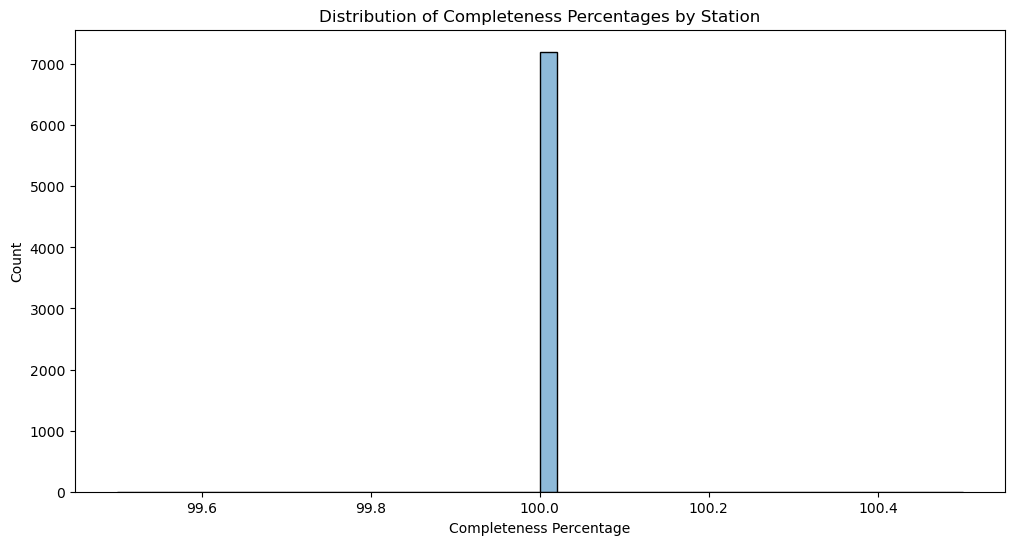

In [81]:
# Calculate completeness statistics for the TAVG column per station
completeness_by_station = filtered_temp_2024_df.groupby('ID')['TAVG'].apply(lambda x: (x.notna().sum() / x.count()) * 100).reset_index()
completeness_by_station.columns = ['ID', 'Completeness_Percentage']

# Overall summary statistics for completeness
min_completeness = completeness_by_station['Completeness_Percentage'].min()
max_completeness = completeness_by_station['Completeness_Percentage'].max()
mean_completeness = completeness_by_station['Completeness_Percentage'].mean()
median_completeness = completeness_by_station['Completeness_Percentage'].median()

print("Overall completeness statistics (in percentage):")
print("Min:", min_completeness)
print("Max:", max_completeness)
print("Mean:", mean_completeness)
print("Median:", median_completeness)

# Also count the number of stations with complete or zero completeness
complete_stations = completeness_by_station[completeness_by_station['Completeness_Percentage'] == 100].shape[0]
zero_stations = completeness_by_station[completeness_by_station['Completeness_Percentage'] == 0].shape[0]

print("Number of stations with 100% completeness:", complete_stations)
print("Number of stations with 0% completeness:", zero_stations)

# Plot histogram of completeness percentages
plt.figure(figsize=(12,6))
sns.histplot(completeness_by_station['Completeness_Percentage'], bins=50, kde=True)
plt.title('Distribution of Completeness Percentages by Station')
plt.xlabel('Completeness Percentage')
plt.ylabel('Count')
plt.savefig('completeness_distribution.png')
plt.show()

#### Summary

Interestingly, after filtering to include only stations that exist in the primary stations dataset, we have perfect completeness in our temperature data. All 7,204 stations have 100% of their temperature values present with no missing data.

This suggests that the missing values we observed earlier were primarily associated with stations that weren't in the primary stations dataset. By filtering to include only stations from the primary dataset, we've effectively removed all records with missing temperature values.

#### Correlation of Station Temperatures using Nearest Neighbors

With a 100% completeness percentage for the NOAA station observations, we will be able to generate a thorough analysis of the correlation of observed temperatures across stations within a 500km radius of each other. Recall that the paper by Hansen and Lebedeff used 1,200km as their distance for correlation measaurement.

The objective of the correlation analysis is to generate a Correlation Coeeficient for each unique station in **temp_2024_df** against the respective neighbor stations idenitified in **neighbors_dict**.

In [86]:
# Convert **DATE** field to datetime
temp_2024_df['DATE'] = pd.to_datetime(temp_2024_df['DATE'])

In [88]:
# Pivot the temperature data to have stations as columns and dates as rows
pivot_temp = temp_2024_df.pivot(index='DATE', columns='ID', values='TAVG')

print(f"Pivot table shape: {pivot_temp.shape}")

Pivot table shape: (366, 7604)


In [90]:
# Initialize a list to store correlation results
correlation_results = []

# Counter for progress tracking
total_stations = len(neighbors_dict)
processed = 0

print("Computing correlations between stations and their neighbors...")
# For each station in the neighbors dictionary
for station_id, neighbors in neighbors_dict.items():
    # Check if the station exists in our temperature data
    if station_id in pivot_temp.columns:
        # For each neighbor of this station
        for neighbor_info in neighbors:
            neighbor_id = neighbor_info[0]
            distance_km = neighbor_info[1]
            
            # Check if the neighbor exists in our temperature data
            if neighbor_id in pivot_temp.columns:
                # Get the temperature data for both stations, dropping any rows with NaN
                station_data = pivot_temp[[station_id, neighbor_id]].dropna()
                
                # If we have enough data points, calculate correlation
                if len(station_data) > 10:  # Requiring at least 10 common data points
                    correlation = station_data[station_id].corr(station_data[neighbor_id])
                    
                    # Store the result
                    correlation_results.append({
                        'Station': station_id,
                        'Neighbor': neighbor_id,
                        'Distance_km': distance_km,
                        'Correlation': correlation,
                        'Common_Data_Points': len(station_data)
                    })
    
    # Update progress
    processed += 1
    if processed % 1000 == 0:
        print(f"Processed {processed}/{total_stations} stations")

Computing correlations between stations and their neighbors...
Processed 1000/14269 stations
Processed 2000/14269 stations
Processed 3000/14269 stations
Processed 4000/14269 stations
Processed 5000/14269 stations
Processed 6000/14269 stations
Processed 7000/14269 stations
Processed 8000/14269 stations
Processed 9000/14269 stations
Processed 10000/14269 stations
Processed 11000/14269 stations
Processed 12000/14269 stations
Processed 13000/14269 stations
Processed 14000/14269 stations


In [92]:
# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

correlation_df.head()

,Station,Neighbor,Distance_km,Correlation,Common_Data_Points
0,USC00010063,USR0000ABAN,0.272217,0.931325,307
1,USC00010063,USC00018812,0.193608,0.961440,300
2,USC00010063,USC00015635,0.154944,0.984249,306
3,USC00010160,USC00010370,0.132522,0.992260,355
4,USC00010178,USW00063892,0.174652,0.964949,295


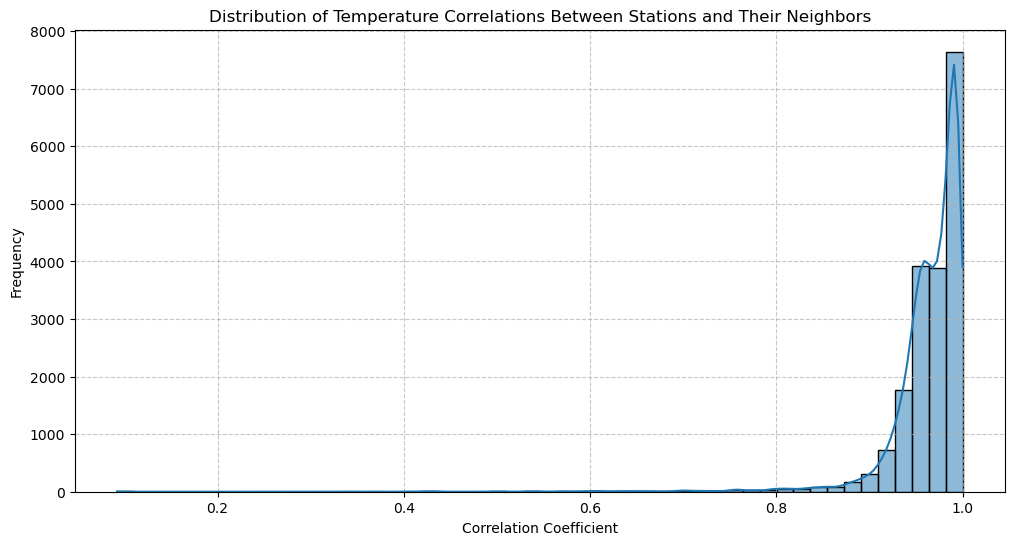

In [96]:
# Histogram of correlations
plt.figure(figsize=(12, 6))
sns.histplot(correlation_df['Correlation'].dropna(), bins=50, kde=True)
plt.title('Distribution of Temperature Correlations Between Stations and Their Neighbors')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

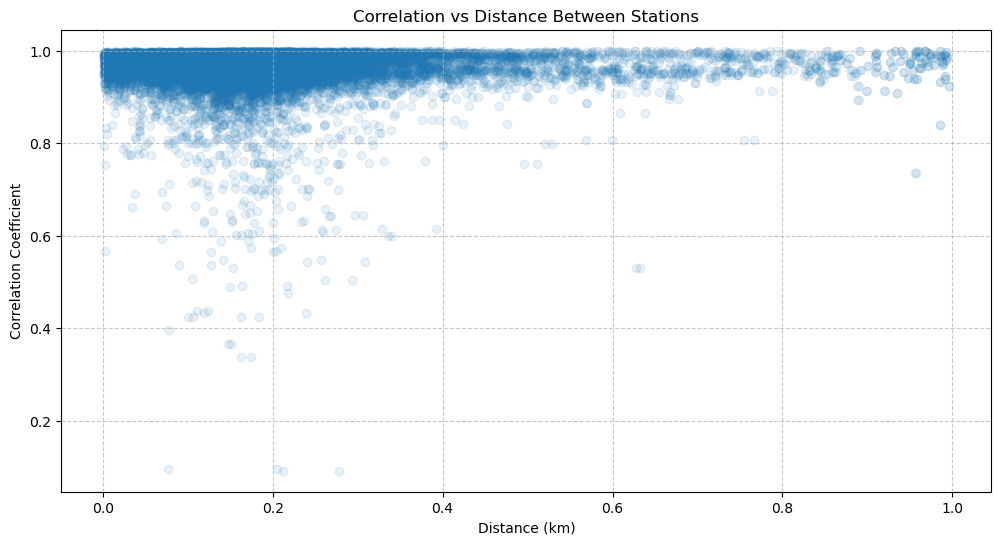

In [98]:
# Scatter plot of distance vs correlation
plt.figure(figsize=(12, 6))
plt.scatter(correlation_df['Distance_km'], correlation_df['Correlation'], alpha=0.1)
plt.title('Correlation vs Distance Between Stations')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [100]:
# Calculate average correlation by station
avg_corr_by_station = correlation_df.groupby('Station')['Correlation'].mean().reset_index()
avg_corr_by_station = avg_corr_by_station.sort_values('Correlation', ascending=False)

print("Top 10 stations with highest average correlation with neighbors:")
print(avg_corr_by_station.head(10))

print("Bottom 10 stations with lowest average correlation with neighbors:")
print(avg_corr_by_station.tail(10))

Top 10 stations with highest average correlation with neighbors:
          Station  Correlation
6477  USW00053136     0.998967
5856  USW00003160     0.998967
1532  USC00211448     0.998897
6907  USW00094963     0.998897
2155  USC00288880     0.998726
6222  USW00014792     0.998726
1437  USC00203331     0.998662
6546  USW00053926     0.998528
2658  USC00348499     0.998526
5932  USW00003965     0.998209
Bottom 10 stations with lowest average correlation with neighbors:
          Station  Correlation
2195  USC00294028     0.592377
4069  USR0000CBIR     0.588072
290   USC00043714     0.587996
469   USC00052932     0.565250
5739  USS0021D12S     0.560258
3484  USC00429491     0.524655
195   USC00034625     0.513498
6693  USW00093112     0.509898
3194  USC00411974     0.476270
6694  USW00093115     0.093692


In [104]:
correlation_df['Correlation'].describe()

count    18911.000000
mean         0.963945
std          0.045128
min          0.092037
25%          0.952450
50%          0.973774
75%          0.990129
max          1.000000
Name: Correlation, dtype: float64

In [106]:
# Let's also look at the individual station-neighbor pairs from the full correlation dataset
corr_pairs = correlation_df
total_pairs = len(corr_pairs)
pairs_above_threshold = (corr_pairs['Correlation'] >= 0.50).sum()
pairs_percentage = (pairs_above_threshold / total_pairs) * 100

print(f"Total number of station-neighbor pairs: {total_pairs}")
print(f"Number of pairs with correlation >= 0.50: {pairs_above_threshold}")
print(f"Percentage of pairs with correlation >= 0.50: {pairs_percentage:.2f}%")

Total number of station-neighbor pairs: 18911
Number of pairs with correlation >= 0.50: 18890
Percentage of pairs with correlation >= 0.50: 99.89%


This means that out of 18,911 stations with average correlations calculated, 18,890 have an average correlation of at least 0.50, which is about 99.89% of the stations.

This result helps confirm the results from Hansen and Lebedeff regarding the correlation of average temperature observations between neighboring stations.

#### Evaluate Percentages Across Different Thresholds for the Correlation Coefficient

In [113]:
# Define several correlation thresholds to check
thresholds = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
results = []

# For each threshold, calculate:
# 1. How many stations have average correlations >= that threshold
# 2. What percentage of total stations that represents
for threshold in thresholds:
    # Count stations with correlation >= threshold
    count = (correlation_df['Correlation'] >= threshold).sum()
    
    # Calculate percentage
    total_stations = len(correlation_df)
    pct = (count / total_stations) * 100
    
    # Store results in a list of dictionaries
    results.append({
        'Threshold': threshold,
        'Count': count,
        'Percentage': pct
    })

# Convert results to a DataFrame for better display
threshold_df = pd.DataFrame(results)

# Display the threshold table
print("Percentage of stations above various correlation thresholds:")
print(threshold_df)

Percentage of stations above various correlation thresholds:
   Threshold  Count  Percentage
0       0.50  18890   99.888954
1       0.60  18866   99.762043
2       0.70  18814   99.487071
3       0.80  18689   98.826080
4       0.90  18120   95.817249
5       0.95  14652   77.478716
6       0.99   4792   25.339749


#### Summary

The results indicate that nearly all stations have very high average correlations with their nearby stations. 

1. **High Consistency in Temperature Measurements**: The fact that the vast majority of stations have high correlations with their nearby neighbors suggests that the temperature readings are very consistent within a local geographic area. This implies that the spatial patterns in temperature are strong and that neighboring stations tend to exhibit similar temperature trends.
2. **Reliability for Imputation**: In scenarios where data might be missing or incomplete, these high correlations serve as a robust basis for imputing or adjusting values based on spatial neighbors. With nearly all stations showing strong agreement, using information from neighboring stations is likely a reliable approach for estimating missing values.
3. **Spatial Homogeneity**: The high levels of correlation (> 0.9 for over 95% of stations) hint at substantial spatial homogeneity in the temperature signals. Nearly all stations share similar temperature dynamics, which is a promising sign for analyses requiring regional aggregation or interpolation.

### Test for Normal Distribution

On of the underlying assumptions in temperature model forecasting is that temperature observations follow a normal distribution. This leads to the assumption that average temperature observations over time provide an accurate measurement in which to make predictions. 

This last section evaluates the temperature distribution for each unique station in **temp_2024_df** to determine if the observations follow a normal distribution. This informs us as to whether the mean temperature or median temperature is a more accurate measurement for prediction.

We will use the Shapiro-Wilk test for normalcy.

In [123]:
# Get unique stations
unique_stations = temp_2024_df['ID'].unique()

In [125]:
# Initialize lists to store results
normality_results = []

# Set a minimum number of observations required for the test
min_observations = 300  # Shapiro-Wilk test requires at least 3 observations, but more is better

# Perform normality test for each station
print("Performing normality tests for each station...")
for station in tqdm(unique_stations):
    # Get TAVG values for this station
    station_data = temp_2024_df[temp_2024_df['ID'] == station]['TAVG'].dropna()
    
    # Skip if not enough observations
    if len(station_data) < min_observations:
        normality_results.append({
            'Station': station,
            'Sample_Size': len(station_data),
            'Shapiro_Statistic': np.nan,
            'Shapiro_P_Value': np.nan,
            'Is_Normal': np.nan,
            'Mean': station_data.mean() if len(station_data) > 0 else np.nan,
            'Std': station_data.std() if len(station_data) > 0 else np.nan
        })
        continue
    
    # Perform Shapiro-Wilk test
    # If sample size > 5000, take a random sample of 5000 (Shapiro-Wilk has limitations for large samples)
    test_data = station_data.sample(min(5000, len(station_data))) if len(station_data) > 5000 else station_data
    shapiro_stat, shapiro_p = stats.shapiro(test_data)
    
    # Store results
    normality_results.append({
        'Station': station,
        'Sample_Size': len(station_data),
        'Shapiro_Statistic': shapiro_stat,
        'Shapiro_P_Value': shapiro_p,
        'Is_Normal': shapiro_p > 0.05,  # p > 0.05 suggests normality
        'Mean': station_data.mean(),
        'Std': station_data.std()
    })

Performing normality tests for each station...


100%|██████████| 7604/7604 [13:46<00:00,  9.20it/s]


In [141]:
# Convert results to DataFrame
normality_df = pd.DataFrame(normality_results)

normality_df.head()

,Station,Sample_Size,Shapiro_Statistic,Shapiro_P_Value,Is_Normal,Mean,Std
0,USC00010063,307,0.952769,2.204248e-08,False,158.407166,83.275011
1,USC00010160,365,0.943595,1.447983e-10,False,179.646575,81.428581
2,USC00010178,297,NaN,NaN,NaN,197.291246,84.512314
3,USC00010260,365,0.945381,2.361578e-10,False,165.035616,89.615579
4,USC00010370,356,0.940414,9.210284e-11,False,161.030899,77.698291


In [131]:
# Summary statistics
normal_count = normality_df['Is_Normal'].sum()
total_tested = normality_df['Is_Normal'].count() - normality_df['Is_Normal'].isna().sum()
normal_percentage = (normal_count / total_tested) * 100 if total_tested > 0 else 0

print("Summary of normality test results:")
print(f"Stations with normally distributed temperatures: {normal_count} out of {total_tested} tested ({normal_percentage:.2f}%)")

Summary of normality test results:
Stations with normally distributed temperatures: 18 out of 6098 tested (0.30%)


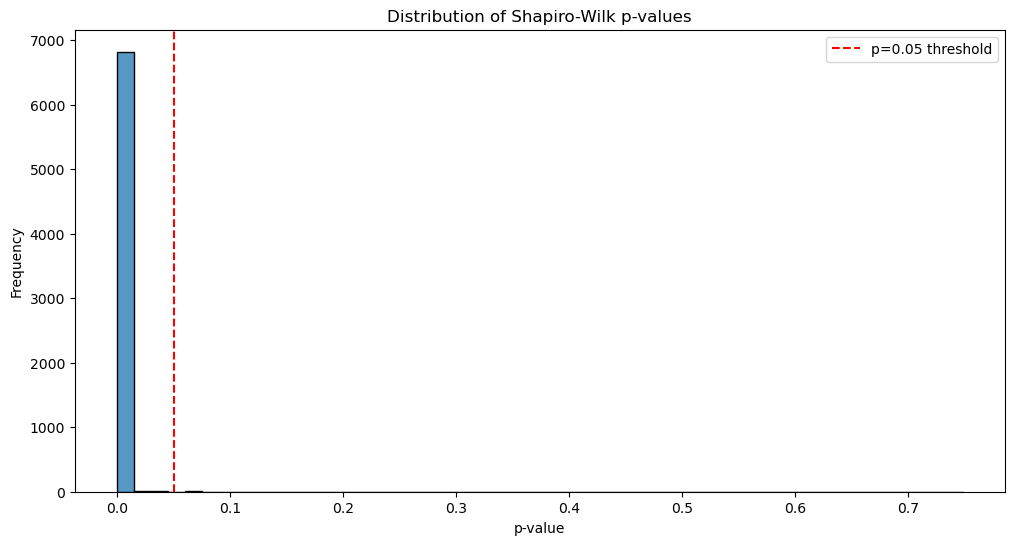

In [133]:
# Histogram of p-values
plt.figure(figsize=(12, 6))
sns.histplot(normality_df['Shapiro_P_Value'].dropna(), bins=50)
plt.title('Distribution of Shapiro-Wilk p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05 threshold')
plt.legend()
plt.show()

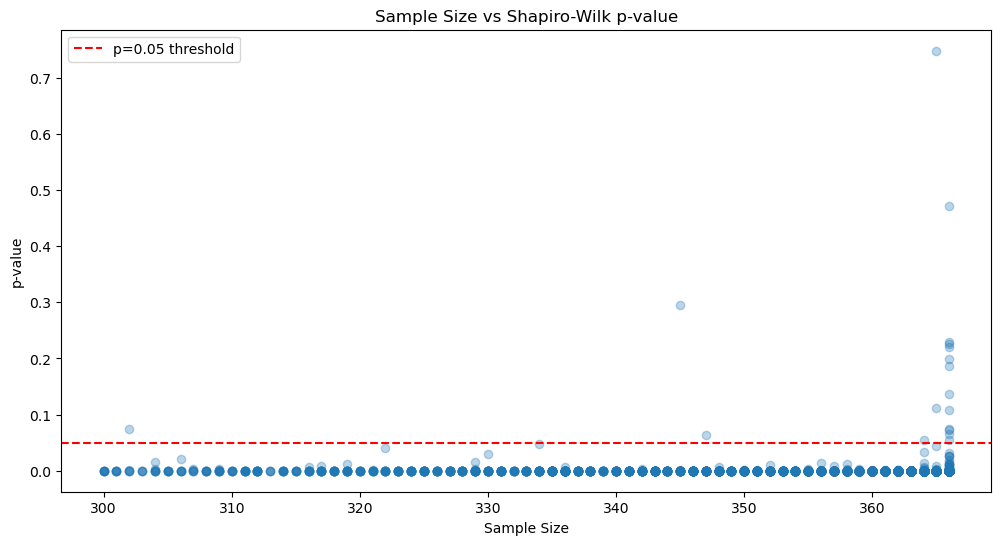

In [135]:
# Sample size vs p-value scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(normality_df['Sample_Size'], normality_df['Shapiro_P_Value'], alpha=0.3)
plt.title('Sample Size vs Shapiro-Wilk p-value')
plt.xlabel('Sample Size')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='p=0.05 threshold')
plt.legend()
plt.show()

In [137]:
# Display top 10 stations with highest p-values (most normal)
top_normal = normality_df.sort_values('Shapiro_P_Value', ascending=False).head(10)

print("Top 10 stations with most normal distributions (highest p-values):")
print(top_normal[['Station', 'Sample_Size', 'Shapiro_P_Value', 'Mean', 'Std']])

Top 10 stations with most normal distributions (highest p-values):
          Station  Sample_Size  Shapiro_P_Value        Mean        Std
306   USC00043714          365         0.748401  125.030137  23.069780
6853  USW00021514          366         0.470944   89.392077  23.471025
294   USC00043161          345         0.295218  117.102899  27.061439
6927  USW00023233          366         0.229427  144.811475  29.460351
4820  USR0000HHAK          366         0.225719  121.161202  20.431207
6937  USW00023273          366         0.219832  136.207650  25.708280
4415  USR0000ATHO          366         0.198483   74.000000  58.776661
4307  USR0000AHLM          366         0.186161   74.431694  62.505798
4833  USR0000HPTA          366         0.135882  144.803279  22.748887
4300  USR0000AHAI          365         0.111933   64.756164  57.651790


In [139]:
# Display bottom 10 stations with lowest p-values (least normal)
bottom_normal = normality_df.sort_values('Shapiro_P_Value').head(10)
print("Bottom 10 stations with least normal distributions (lowest p-values):")
print(bottom_normal[['Station', 'Sample_Size', 'Shapiro_P_Value', 'Mean', 'Std']])

Bottom 10 stations with least normal distributions (lowest p-values):
          Station  Sample_Size  Shapiro_P_Value        Mean         Std
7416  USW00093845          361     4.067482e-33  223.002770  138.725038
6862  USW00022534          364     1.654833e-32  248.635989   40.783157
4472  USR0000CBIR          356     4.265050e-28  131.061798  136.434193
2294  USC00294028          364     4.411372e-27  190.993132  145.453714
4772  USR0000DIAM          363     4.572851e-24   76.763085  140.960435
7350  USW00093112          311     5.530701e-24  131.975884  117.075569
7317  USW00073805          364     7.461206e-24  216.947802   89.218354
7175  USW00053907          364     2.669058e-23  210.571429  106.688214
4238  USC00519281          366     1.172968e-21  238.890710   20.477761
5872  USS0012J02S          366     3.813014e-21   78.174863  102.387082


#### Summary

The results clearly show that the vast majority of stations (99.7%) fail the Shapiro-Wilk normality test, suggesting that daily average temperatures do not follow a normal distribution at most weather stations.

This finding has important implications in terms of proper prediction modeling.

1. **Mean vs Median**: Using the median might be more appropriate than the mean for temperature data. The median is more robust to non-normal distributions and less affected by outliers or skewness in the data.
2. **Statistical Assumptions**: Many statistical methods (like t-tests, ANOVA, and certain regression techniques) assume normality. The results suggest we should be cautious when applying these methods to raw temperature data without transformation.
3. **Alternative Approaches**: If normality is required for prediction modeling, data transformations (log, Box-Cox) may be required. Since seasonality may play a role in the non-normal distribution of observations, models that account for seasonality would be appropriate. Otherwise, non-parametric methods that don't assume normality would be recommended.

## Conclusion

1. **High Spatial Consistency**: The correlation analysis between neighboring stations revealed extremely high correlations. The vast majority of station pairs exceed 0.90, indicating that temperature readings tend to be very similar among nearby stations. This strong spatial consistency implies that neighboring observations can be reliably used for imputation or validation purposes.
2. **Robustness of Neighbor-Based Imputation**: Given that nearly all station-neighbor pairs exhibit highly correlated temperature trends even within a radius of 500 km, spatial imputation methods leveraging data from neighboring stations are likely to be effective.
3. **Non-Normality of Temperature Observations**: The normality tests (using the Shapiro-Wilk method) show that almost all stations fail to adhere to a normal distribution (only about 0.30% appear normal). This suggests that the distribution of temperature observations is influenced by factors such as seasonality, skewness, and possibly multimodality, making the use of the mean as a sole metric potentially misleading.
4. **Implications for Statistical Analysis**: Due to the absence of normality in the temperature data, relying on averages might not be optimal. The median, being more robust to skewed or multimodal distributions, could be a better measure for central tendency. Moreover, any statistical analyses or predictive models that assume normality should be approached with caution, and alternatives like non-parametric methods or data transformations might be more appropriate.

The project underscores that while temperature data exhibits strong spatial correlation, making neighbor-based approaches valuable, the underlying distributions are not normal. This suggests that practical applications, especially prediction and imputation efforts, should consider using robust measures like the median and possibly transform or adapt statistical methods to account for the non-normal distribution of observed temperatures.